In [ ]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from pykrx import stock

## ETF 종목 상관계수 분석
- 목표: 다양한 ETF 간의 상관성을 분석하고 분산투자 가능성을 탐색

In [ ]:
# 날짜 설정
start_date = '20220101'
end_date = '20241231'

# 모든 ETF 티커 리스트 가져오기
etf_list = stock.get_etf_ticker_list()
# 모든 ETF 이름 리스트 가져오고 etf_name 변수에 담기
etf_name = [stock.get_etf_ticker_name(etf) for etf in etf_list]

In [ ]:
# concate DataFrames
df_etf = pd.DataFrame()
# for etf_number in etf_list[:3]:
for etf_number in etf_list:
    try:
        df_etf[etf_number] = stock.get_etf_ohlcv_by_date(start_date, end_date, etf_number)['종가']
        # df_etf = stock.get_etf_ohlcv_by_date(start_date, end_date, etf_number)
    except:
        print(etf_number)
        pass


# def fetch_etf_data(etf_number):
#     try:
#         return etf_number, stock.get_etf_ohlcv_by_date(start_date, end_date, etf_number)['종가']
#     except:
#         pass

# # 멀티프로세싱을 사용하여 병렬로 데이터 가져오기
# with mp.Pool(processes=4) as pool:
#     results = pool.map(fetch_etf_data, etf_list)

# # 결과를 데이터프레임으로 변환
# df_etf = pd.DataFrame({etf: data for etf, data in results if data is not None})

In [110]:
df_etf

,461600,453850,278530
날짜,,,
2022-01-03,NaN,NaN,13115
2022-01-04,NaN,NaN,13110
2022-01-05,NaN,NaN,12925
2022-01-06,NaN,NaN,12790
2022-01-07,NaN,NaN,12950
...,...,...,...
2024-12-23,8935.0,7935.0,11370
2024-12-24,8860.0,7875.0,11375
2024-12-26,8845.0,7865.0,11325


#### 모든 ETF 간 상관계수 행렬계산

In [ ]:

# df_etf
# df_etf.corr()
corr_etf = df_etf.corr()

#### 상관계수가 높은 종목과 낮은 종목을 구분

In [33]:
# 상관계수가 높은 종목과 낮은 종목을 구분
sorted_corr_etf = corr_etf.unstack().sort_values(ascending=False) # 모든 조합 정렬
sorted_corr_etf = sorted_corr_etf[sorted_corr_etf < 1]
highest = sorted_corr_etf.idxmax() # 가장 높은 상관계수
lowest = sorted_corr_etf.idxmin() # 가장 낮은 상관계수

highest, lowest
# highest = (한국투자 ACE 단기자금증권상장지수투자신탁(채권), KOSEF 단기자금)
# lowest = (KODEX 미국달러선물인버스, TIGER 미국달러SOFR금리액티브(합성))

(('190620', '130730'), ('261270', '456610'))

#### 상관계수를 바탕으로 다각화된 투자에 적합한 종목 조합
- 음의 관계를 띄는 것을 선택

In [39]:
# 중복된 ETF 조합 제거
lowest_corr_pairs = sorted_corr_etf.nsmallest(100)  # 50개보다 2배 더 뽑음 (중복 제거 과정 필요)

# ETF1 - ETF2 쌍을 튜플 형태로 변환 (정렬하여 동일 조합 제거)
unique_lowest_corr_pairs = set()
final_lowest_corr = []

for etf1, etf2 in lowest_corr_pairs.index:
    pair = tuple(sorted([etf1, etf2]))  # (작은 숫자, 큰 숫자) 형태로 정렬하여 중복 방지
    if pair not in unique_lowest_corr_pairs:
        unique_lowest_corr_pairs.add(pair)
        final_lowest_corr.append((etf1, etf2, lowest_corr_pairs[(etf1, etf2)]))

# 최종 5개 ETF 조합 출력
final_lowest_corr = final_lowest_corr[:5]
for etf1, etf2, corr in final_lowest_corr:
    print(f"ETF1: {etf1}, ETF2: {etf2}, 상관계수: {corr:.6f}")

ETF1: 261270, ETF2: 456610, 상관계수: -0.999166
ETF1: 261240, ETF2: 261260, 상관계수: -0.999137
ETF1: 261260, ETF2: 456610, 상관계수: -0.999101
ETF1: 261270, ETF2: 261240, 상관계수: -0.999074
ETF1: 261260, ETF2: 261250, 상관계수: -0.998996


## 샤프 지수를 사용한 최적 포트폴리오 구성
- 목표: 상관계수 분석을 통해 선별한 일부 ETF 종목으로 최적의 투자 비율을 찾습니다.

##### 선택된 ETF 종목의 일간 수익률 데이터를 기반으로 평균 수익률과 공분산 행렬을 계산

In [44]:
# 선택된 ETF 조합 (위에서 구한 상관계수 낮은 ETF 들)
selected_etfs = list(set([etf for pair in lowest_corr_pairs.index for etf in pair]))

In [45]:
# 선택된 ETF들의 수익률 계산
returns = df_etf[selected_etfs].pct_change().dropna()

# 평균 수익률 및 공분산 행렬 계산
mean_returns = returns.mean()
cov_matrix = returns.cov()

##### 무위험 이자율을 설정하고 샤프 지수를 최대화하는 포트폴리오의 가중치를 찾기
##### 최적 가중치, 포트폴리오 기대 수익률, 변동성, 샤프 지수 도출

In [53]:
# 무위험 수익률 설정 (예 : 한국 국채 금리 3% 가정)
risk_free_rate = 0.03 / 252 # 연간 3%를 일간 수익률로 변환
num_portfolios = 100000 # 시뮬레이션할 포트폴리오 개수

# 포트폴리오 수익률, 변동성, 샤프 지수 저장 리스트
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    
    # 가중치 생성
    weights = np.random.dirichlet(np.ones(len(selected_etfs)), size=1)[0] 
    weights_record.append(weights)
    
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # 샤프 지수
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio
    
# 샤프 지수가 가장 높은 포트폴리오 선택
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]
optimal_return = results[0, max_sharpe_idx]
optimal_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

print("\n 최적 포트폴리오 결과")
print(f"ETF 가중치: {dict(zip(selected_etfs, optimal_weights))}")
print(f"기대 수익률: {optimal_return:.4f}")
print(f"변동성: {optimal_volatility:.4f}")
print(f"샤프 지수: {max_sharpe_ratio:.4f}")


 최적 포트폴리오 결과
ETF 가중치: {'114800': 0.007939287125635533, '261120': 0.020915443162907874, '261260': 0.02890891454845826, '138230': 0.0752886625108433, '453850': 0.0023561650681425722, '069500': 0.026044429607556263, '455030': 0.040392398373986706, '456610': 0.007866123526945424, '304670': 0.12451863798598384, '304660': 0.009811648586840006, '225800': 0.11769774621190296, '261110': 0.008475985486183803, '460270': 0.06827900125974799, '440650': 0.006752997740794305, '310960': 0.031073444192738615, '461600': 0.0058320374526790435, '261270': 0.019364809302391612, '261240': 0.03127993851431368, '469530': 0.022997762893375146, '491220': 0.04409549592868425, '456880': 0.12358148815821685, '252410': 0.046226722642105554, '261250': 0.021613452076866844, '361580': 0.014505819222793395, '148020': 0.04537825615590333, '230480': 0.021684567463188968, '452250': 0.02612300684161133, '278530': 0.00099575795920273}
기대 수익률: 0.0015
변동성: 0.0014
샤프 지수: 0.9975


In [58]:
selected_etfs, optimal_weights

(['114800',
  '261120',
  '261260',
  '138230',
  '453850',
  '069500',
  '455030',
  '456610',
  '304670',
  '304660',
  '225800',
  '261110',
  '460270',
  '440650',
  '310960',
  '461600',
  '261270',
  '261240',
  '469530',
  '491220',
  '456880',
  '252410',
  '261250',
  '361580',
  '148020',
  '230480',
  '452250',
  '278530'],
 array([0.00793929, 0.02091544, 0.02890891, 0.07528866, 0.00235617,
        0.02604443, 0.0403924 , 0.00786612, 0.12451864, 0.00981165,
        0.11769775, 0.00847599, 0.068279  , 0.006753  , 0.03107344,
        0.00583204, 0.01936481, 0.03127994, 0.02299776, 0.0440955 ,
        0.12358149, 0.04622672, 0.02161345, 0.01450582, 0.04537826,
        0.02168457, 0.02612301, 0.00099576]))

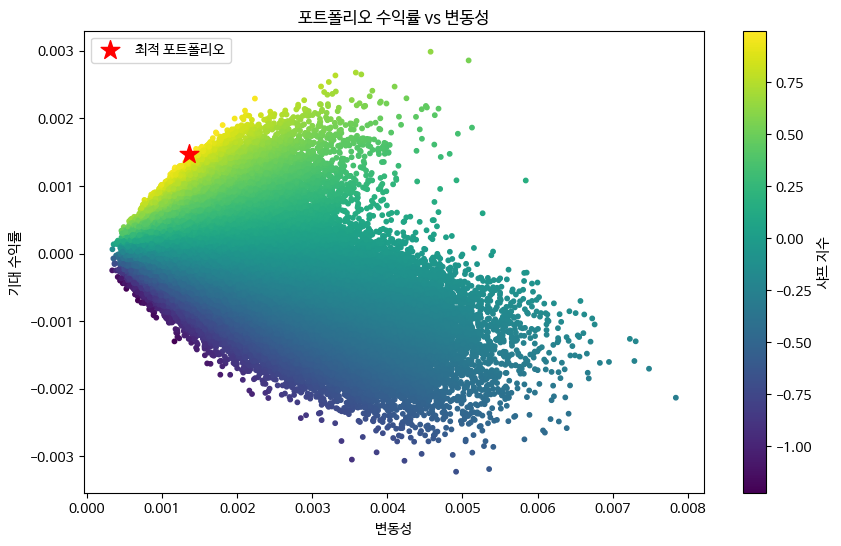

In [54]:
import matplotlib.pyplot as plt

# 포트폴리오 수익률과 변동성에 대한 산점도 그래프
plt.figure(figsize = (10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10)
plt.title('포트폴리오 수익률 vs 변동성')
plt.xlabel('변동성')
plt.ylabel('기대 수익률')
plt.colorbar(label='샤프 지수')

# 최적 샤프 지수를 가지는 포트폴리오 강조
plt.scatter(optimal_volatility, optimal_return, marker='*', color='r', s=200, label='최적 포트폴리오')
plt.legend(loc='upper left')

# 차트 출력
plt.show()

In [71]:
from pykrx import stock

# ETF 가중치 데이터
etf_weights = {
    '114800': 0.007939287125635533, '261120': 0.020915443162907874, '261260': 0.02890891454845826, 
    '138230': 0.0752886625108433, '453850': 0.0023561650681425722, '069500': 0.026044429607556263, 
    '455030': 0.040392398373986706, '456610': 0.007866123526945424, '304670': 0.12451863798598384, 
    '304660': 0.009811648586840006, '225800': 0.11769774621190296, '261110': 0.008475985486183803, 
    '460270': 0.06827900125974799, '440650': 0.006752997740794305, '310960': 0.031073444192738615, 
    '461600': 0.0058320374526790435, '261270': 0.019364809302391612, '261240': 0.03127993851431368, 
    '469530': 0.022997762893375146, '491220': 0.04409549592868425, '456880': 0.12358148815821685, 
    '252410': 0.046226722642105554, '261250': 0.021613452076866844, '361580': 0.014505819222793395, 
    '148020': 0.04537825615590333, '230480': 0.021684567463188968, '452250': 0.02612300684161133, 
    '278530': 0.00099575795920273
}

# ETF 코드별 이름 가져오고 가중치 기준 정렬
etf_info = [(code, stock.get_etf_ticker_name(code), weight) for code, weight in etf_weights.items()]
sorted_etf_info = sorted(etf_info, key=lambda x: x[2], reverse=True)  # 가중치 기준 내림차순 정렬

# 정렬된 ETF 정보 출력
print(f"{'ETF 코드':<10} {'ETF 이름':<50} {'가중치':<10}")
print("=" * 80)
for code, name, weight in sorted_etf_info:
    print(f"{code:<10} {name:<50} {weight:.6f}")


ETF 코드     ETF 이름                                             가중치       
304670     KODEX 미국30년국채울트라선물인버스(H)                           0.124519
456880     ACE 미국달러SOFR금리(합성)                                 0.123581
225800     KIWOOM 미국달러선물레버리지                                  0.117698
138230     KIWOOM 미국달러선물                                      0.075289
460270     KIWOOM 미국달러SOFR금리액티브(합성)                           0.068279
252410     RISE 200선물인버스                                      0.046227
148020     RISE 200                                           0.045378
491220     PLUS 200TR                                         0.044095
455030     KODEX 미국달러SOFR금리액티브(합성)                            0.040392
261240     KODEX 미국달러선물                                       0.031280
310960     TIGER 200TR                                        0.031073
261260     KODEX 미국달러선물인버스2X                                  0.028909
452250     ACE 미국30년국채선물레버리지(합성 H)                            0.026123
0695

#### 가중치가 높은 상위 3개의 종목 시각화

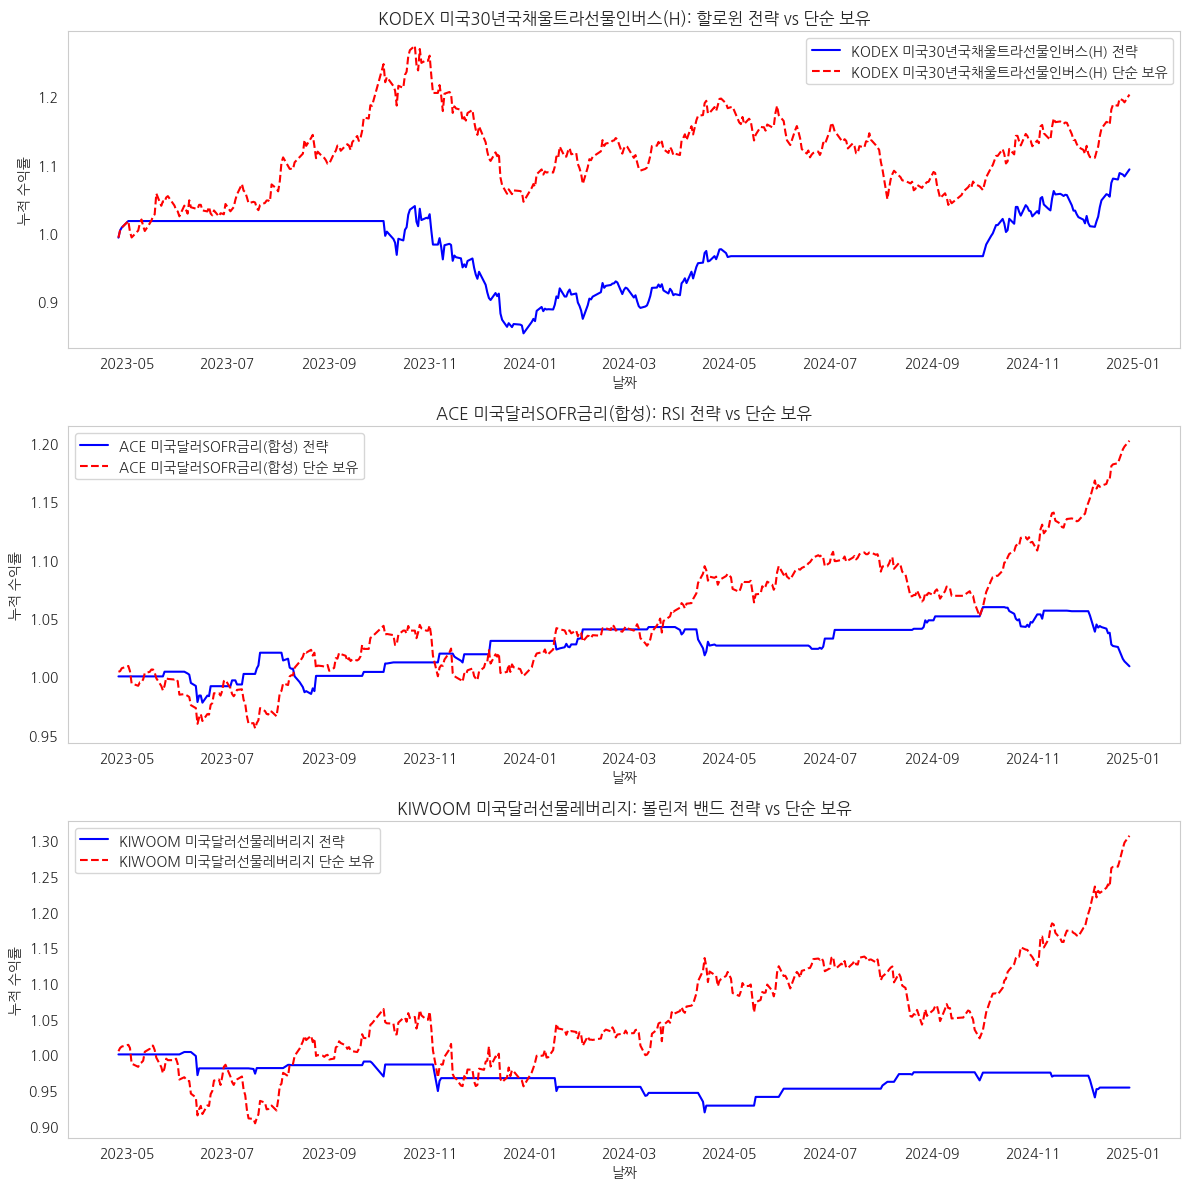

In [101]:
plt.rcParams['font.family'] = 'NanumGothic'

# 설정: ETF 리스트 및 날짜
highest_etf_list = ['304670', '456880', '225800']  # 선택된 3개 ETF
start_date = '20220101'
end_date = '20241231'

# ETF 코드에 대한 실제 이름과 전략 매칭
highest_etf_names = {
    '304670': 'KODEX 미국30년국채울트라선물인버스(H)',
    '456880': 'ACE 미국달러SOFR금리(합성)',
    '225800': 'KIWOOM 미국달러선물레버리지'
}

highest_etf_strategies = {
    '304670': '할로윈 전략',
    '456880': 'RSI 전략',
    '225800': '볼린저 밴드 전략'
}

# 데이터 가져오기
df_etf = pd.DataFrame()
for etf in highest_etf_list:
    df_etf[etf] = stock.get_etf_ohlcv_by_date(start_date, end_date, etf)['종가']

df_etf = df_etf.dropna()

# 로그 수익률 계산: 로그 수익률을 사용하는 이유는 연속적인 변동성을 더 잘 반영하고, 장기적으로 합산 가능하기 때문
# 로그 수익률 공식: log(P_t / P_(t-1))
df_returns = np.log(df_etf / df_etf.shift(1))

def rsi(df, window=14):
    delta = df.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def bollinger_bands(df, window=20):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

# 전략 적용: 각 ETF에 대해 개별 전략
signals = pd.DataFrame(index=df_etf.index)

# KODEX 미국30년국채울트라선물인버스(H)(304670): 할로윈 전략 적용 (10월~4월 매수, 나머지 매도)
# 할로윈전략 선택이유: 채권형 ETF는 경기 변동성이 낮은 겨울철에 상대적으로 강세를 보이는 경향이 있음
signals['304670'] = df_etf.index.month.isin([10, 11, 12, 1, 2, 3, 4]).astype(int)

# ACE 미국달러SOFR금리(합성)(456880): RSI 전략 (RSI<30 매수, RSI>70 매도)
# 이유: 금리 관련 ETF는 과매도(30 이하) 시 반등 가능성이 높고, 과매수(70 이상) 시 조정 가능성이 높음
rsi_456880 = rsi(df_etf['456880'])
signals['456880'] = np.where(rsi_456880 < 30, 1, np.where(rsi_456880 > 70, -1, 0))

# KIWOOM 미국달러선물레버리지(225800): 볼린저 밴드 전략 (하단선 매수, 상단선 매도)
# 이유: 달러 선물 ETF는 변동성이 커서 볼린저 밴드와 같은 변동성 기반 전략이 유효함
upper, lower = bollinger_bands(df_etf['225800'])
signals['225800'] = np.where(df_etf['225800'] < lower, 1, np.where(df_etf['225800'] > upper, -1, 0))

# 비교 대조군: 단순 보유 전략 (Buy and Hold)
buy_and_hold_returns = (1 + df_returns).cumprod()

# 전략별 수익률 계산
strategy_returns = signals.shift(1) * df_returns
cumulative_returns = (1 + strategy_returns).cumprod()

# 결과 시각화 (각 ETF별 개별 그래프 출력)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
for i, etf in enumerate(highest_etf_list):
    axes[i].plot(cumulative_returns[etf], label=f'{highest_etf_names[etf]} 전략', color='blue')
    axes[i].plot(buy_and_hold_returns[etf], linestyle='dashed', label=f'{highest_etf_names[etf]} 단순 보유', color='red')
    axes[i].set_title(f'{highest_etf_names[etf]}: {highest_etf_strategies[etf]} vs 단순 보유')  # 제목에 전략 추가
    axes[i].set_xlabel('날짜')
    axes[i].set_ylabel('누적 수익률')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

#### 가중치가 낮은 하위 3개의 종목 시각화

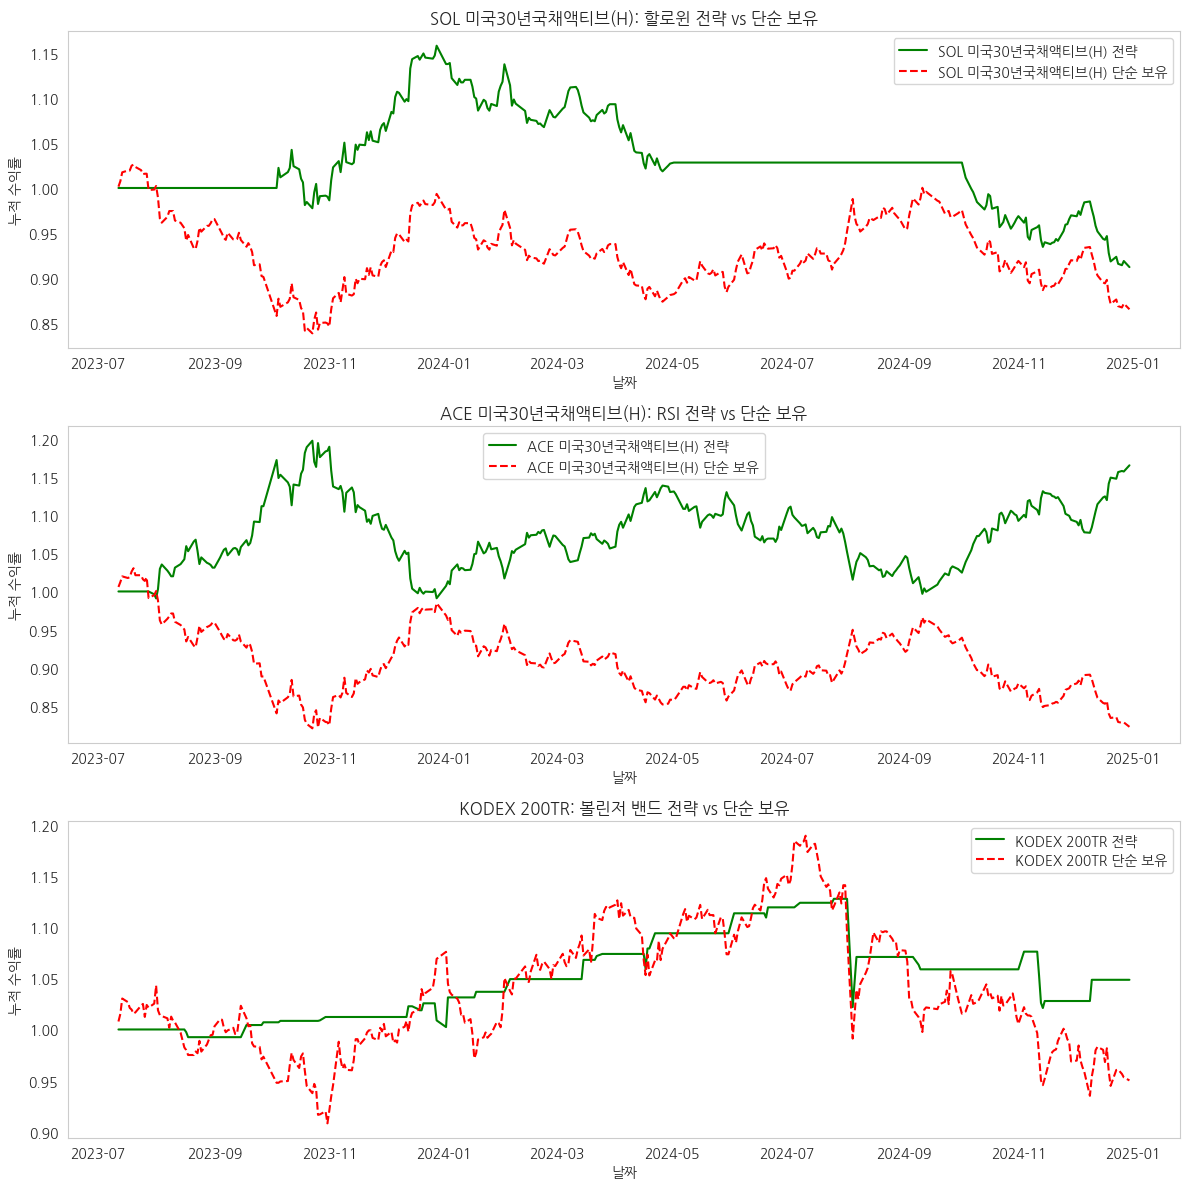

In [102]:

plt.rcParams['font.family']='NanumGothic'

# 설정 : ETF 리스트 및 날짜
lowest_etf_list = ['461600','453850','278530'] # 가중치 가장 낮은 3개 ETF
start_date = '20220101'
end_date = '20241231'

# ETF 코드에 대한 실제 이름과 전략 매칭
lowest_etf_names = {
    '461600': 'SOL 미국30년국채액티브(H)',
    '453850': 'ACE 미국30년국채액티브(H)',
    '278530': 'KODEX 200TR'
}

lowest_etf_strategies = {
    '461600': '할로윈 전략',
    '453850': 'RSI 전략',
    '278530': '볼린저 밴드 전략'
}

# 데이터 가져오기
df_etf = pd.DataFrame()
for etf in lowest_etf_list:
    df_etf[etf] = stock.get_etf_ohlcv_by_date(start_date, end_date, etf)['종가']

df_etf = df_etf.dropna()

# 로그 수익률 계산: 로그 수익률을 사용하는 이유는 연속적인 변동성을 더 잘 반영하고, 장기적으로 합산 가능하기 때문
# 로그 수익률 공식: log(P_t / P_(t-1))
df_returns = np.log(df_etf / df_etf.shift(1))

def rsi(df, window=14):
    delta = df.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 -(100 / (1 + rs))

def bollinger_bands(df, window=20):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

# 전략 적용: 각 ETF에 대해 개별 전략
signals = pd.DataFrame(index=df_etf.index)

# SOL 미국30년국채액티브(H)(461600): 할로윈 전략 (10월~4월 매수, 나머지 매도)
# 이유: 장기 채권 관련 ETF는 계절성 효과가 존재할 가능성이 있어 할로윈 전략 적용
signals['461600']= df_etf.index.month.isin([10, 11, 12, 1, 2, 3, 4]).astype(int)

# ACE 미국30년국채액티브(H)(453850): RSI 전략 (RSI<30 매수, RSI>70 매도)
# 이유: 미국 30년 국채 ETF는 과매도 시 반등 가능성이 크므로 RSI 전략 적용
rsi_453850 = rsi(df_etf['453850'])
signals['453850'] = np.where(rsi_453850 < 30, 1, np.where(rsi_453850 > 70, -1, 0))

# KODEX 200TR (278530) : 볼린저 밴드 전략 (하단선 매수, 상단선 매도)
# 이유: KODEX 200TR은 변동성이 존재하므로 볼린저 밴드를 활용한 전략 적용
upper, lower = bollinger_bands(df_etf['278530'])
signals['278530'] = np.where(df_etf['278530'] < lower, 1, np.where(df_etf['278530'] > upper, -1, 0))

# 비교 대조군: 단순 보유 전략 (Buy and Hold)
buy_and_hold_returns = (1 + df_returns).cumprod()

# 전략별 수익률 계산
strategy_returns = signals.shift(1) * df_returns
cumulative_returns = (1+ strategy_returns).cumprod()

# 결과 시각화 (각 ETF별 개별 그래프 출력)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
for i, etf in enumerate(lowest_etf_list):
    axes[i].plot(cumulative_returns[etf], label=f'{lowest_etf_names[etf]} 전략', color='green')
    axes[i].plot(buy_and_hold_returns[etf], linestyle='dashed', label=f'{lowest_etf_names[etf]} 단순 보유', color='red')
    axes[i].set_title(f'{lowest_etf_names[etf]}: {lowest_etf_strategies[etf]} vs 단순 보유')
    axes[i].set_xlabel('날짜')
    axes[i].set_ylabel('누적 수익률')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()